In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
import seaborn as sns
%matplotlib inline

/home/seb/py36/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


This notebook shows how to construct the number of excess deaths (relative to a counterfactual 2020) from data on total deaths. It then compares these excess deaths to the counterfactual including Covid-19 deaths.

- The source for the mortality data is: https://evm.min-saude.pt/, a real-time mortality data website from the Portuguese Ministry of Health. To update, go to "Quadros -> Total -> Exportar -> CSV".

- The source for the official Covid-19 deaths is https://github.com/dssg-pt/covid19pt-data, a website run by volunteers that scrapes data from the official daily reports of the Portuguese Health DG (DGS). Data has the date of report release, but refers to the previous day.

# 1) Processing the mortality data

In [2]:
def convert_months(month):
    
    months = {}
    months['Abr'] = '04'
    months['Ago'] = '08'
    months['Dez'] = '12'
    months['Fev'] = '02'
    months['Jan'] = '01'
    months['Jul'] = '07'
    months['Jun'] = '06'
    months['Mai'] = '05'
    months['Mar'] = '03'
    months['Nov'] = '11'
    months['Out'] = '10'
    months['Set'] = '09'
    
    return months[month]

In [3]:
df = pd.read_csv('./mortality_data/Dados_SICO_2020-04-12.csv',
                 encoding = "UTF-8")

df = df[['Data (mm-dd)'] + ['{}'.format(yr) for yr in range(2015,2021)]].reset_index(drop=True).copy(deep=True)

df['aux'] = df['Data (mm-dd)'].str[:3]
df['month'] = df.aux.apply(lambda x: convert_months(x))
df['day'] = df['Data (mm-dd)'].str[-2:]
df['monthday'] = pd.to_numeric(df.month + df.day)
df['date'] = "2020-" + df['month'] + "-" + df['day']
df['date']  =  pd.to_datetime(df['date'] , format='%Y%m%d', errors='ignore')

df = df[['monthday'] + ['{}'.format(yr) for yr in range(2015,2021)] + ['date']]

dropping all dates before first covid death (march 16, start on the 15th)

In [4]:
first_day = 315
df = df[df['monthday'] >= first_day].reset_index(drop=True).copy(deep=True)

computing cumulative totals

In [5]:
for i in range(2015, 2021):
    df['cs_{}'.format(i)] = df['{}'.format(i)].cumsum()
    del df['{}'.format(i)]

computing growth rate for each year 2015-2019

In [6]:
for yr in range(2015, 2020):
    df['gr_{}'.format(yr)] = df['cs_{}'.format(yr)] / df['cs_{}'.format(yr)].shift(1)
    del df['cs_{}'.format(yr)]

computing average daily growth 2015-2019

In [7]:
df['daily_growth'] = df.loc[:,['gr_{}'.format(yr) for yr in range(2015,2020)]].mean(axis=1)
df = df.drop(['gr_{}'.format(yr) for yr in range(2015,2020)], axis=1)

extrapolating forward

In [8]:
df['counterfactual'] = 0
df.loc[0,'counterfactual'] = df.loc[df.monthday==first_day,'cs_2020'].values[0]

In [9]:
for i in range(1, df.shape[0]):
    df.loc[i,'counterfactual'] = df.loc[i-1,'counterfactual'] * df.loc[i,'daily_growth']

In [10]:
df = df.drop(['daily_growth'], axis=1)

In [11]:
df = df[~pd.isnull(df.cs_2020)]

# 2) Processing the covid data

In [12]:
official = pd.read_csv('./COVID19_data/data.csv')[['data', 'obitos']]

# move date one day backwards, as the report is from the previous day
official['data'] = official.data.shift(1)

official["month"] = official.data.str[3:5]
official["day"] = official.data.str[0:2]
official["monthday"] = pd.to_numeric(official.month + official.day)

official = official.rename(columns={"data": "date"})

official = official[official['monthday'] >= first_day]
official = official.reset_index(drop=True).copy(deep=True)

del official['date']

# 3) Merging and plotting

In [13]:
df_merge = pd.merge(df, official, on=['monthday'], how='right')
df_merge = df_merge.fillna(0)
df_merge['counterfactual_2020_covid'] = df_merge.counterfactual + df_merge.obitos

In [14]:
df_merge.index=df_merge.date
df_merge = df_merge[['cs_2020', 'counterfactual', 'counterfactual_2020_covid']]
df = df_merge.copy(deep=True)

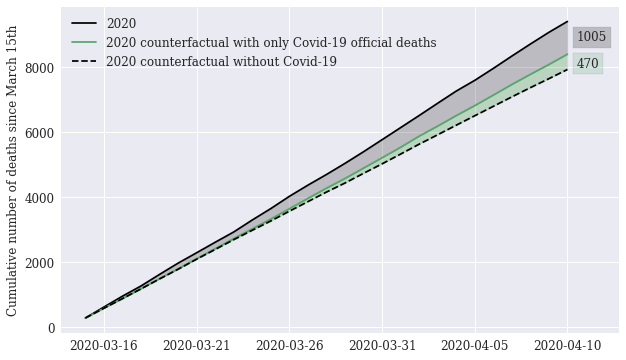

In [15]:
palette = sns.color_palette()

f = plt.figure(figsize=(10,6))
ax = plt.subplot(1,1,1)

ax.plot(df.index,
        df['cs_2020'],
        label='2020',
        color='black')
ax.plot(df.index,
        df['counterfactual_2020_covid'],
        label='2020 counterfactual with only Covid-19 official deaths',
        color = palette[1])
ax.plot(df.index,
        df['counterfactual'],
        label='2020 counterfactual without Covid-19',
        color='black', 
        linestyle = '--')
ax.set_xticks(df.index[[1,6,11,16,21,26]])
ax.fill_between(df.index, df['cs_2020'], df['counterfactual_2020_covid'], color='black', alpha='0.2')
ax.fill_between(df.index, df['counterfactual_2020_covid'], df['counterfactual'], color='green', alpha='0.2')

ax.set_ylabel('Cumulative number of deaths since March 15th',size=12)
ax.tick_params(axis='both', which='major', labelsize=12)

ax.legend(loc='upper left',
          fontsize=12)

plot_margin = 1.5

x0, x1, y0, y1 = plt.axis()
plt.axis((x0,
          x1 + plot_margin,
          y0,
          y1))

plt.text(26.5, 8000, '{}'.format(int(round(df.iloc[-1, 2] - df.iloc[-1, 1]))),
         bbox=dict(facecolor=palette[1], alpha=0.2), size=12)

plt.text(26.5, 8800, '{}'.format(int(round(df.iloc[-1, 0] - df.iloc[-1, 2]))),
         bbox=dict(facecolor='black', alpha=0.2), size=12)

plt.show()

f.savefig('_portugal.pdf', bbox_inches='tight', dpi=100)

In [16]:
print('Official covid-deaths: {} = green - dashed black'.format(round(df.iloc[-1, 2] - df.iloc[-1, 1])))
print('Excess deaths: {} = solid black - dashed black'.format(round(df.iloc[-1, 0] - df.iloc[-1, 1])))
print('Unexplained excess deaths: {} = solid black - green'.format(round(df.iloc[-1, 0] - df.iloc[-1, 2])))

Official covid-deaths: 470.0 = green - dashed black
Excess deaths: 1475.0 = solid black - dashed black
Unexplained excess deaths: 1005.0 = solid black - green


## 3.1) Second plot until April 9th

In [17]:
df = df.iloc[:-1,:].copy(deep=True)

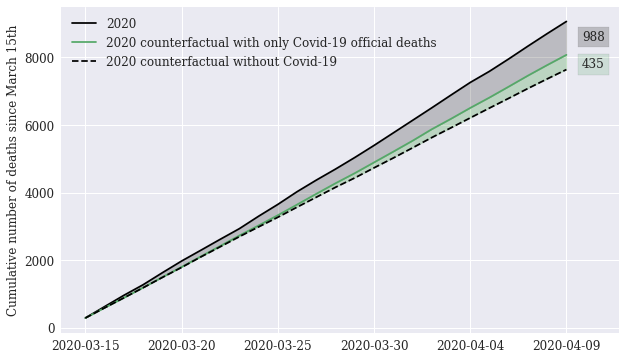

In [18]:
palette = sns.color_palette()

f = plt.figure(figsize=(10,6))
ax = plt.subplot(1,1,1)

ax.plot(df.index,
        df['cs_2020'],
        label='2020',
        color='black')
ax.plot(df.index,
        df['counterfactual_2020_covid'],
        label='2020 counterfactual with only Covid-19 official deaths',
        color = palette[1])
ax.plot(df.index,
        df['counterfactual'],
        label='2020 counterfactual without Covid-19',
        color='black', 
        linestyle = '--')
ax.set_xticks(df.index[[0,5,10,15,20,25]])
ax.fill_between(df.index, df['cs_2020'], df['counterfactual_2020_covid'], color='black', alpha='0.2')
ax.fill_between(df.index, df['counterfactual_2020_covid'], df['counterfactual'], color='green', alpha='0.2')

ax.set_ylabel('Cumulative number of deaths since March 15th',size=12)
ax.tick_params(axis='both', which='major', labelsize=12)

ax.legend(loc='upper left',
          fontsize=12)

plot_margin = 1.5

x0, x1, y0, y1 = plt.axis()
plt.axis((x0,
          x1 + plot_margin,
          y0,
          y1))

plt.text(25.8, 7700, '{}'.format(int(round(df.iloc[-1, 2] - df.iloc[-1, 1]))),
         bbox=dict(facecolor=palette[1], alpha=0.2), size=12)

plt.text(25.8, 8500, '{}'.format(int(round(df.iloc[-1, 0] - df.iloc[-1, 2]))),
         bbox=dict(facecolor='black', alpha=0.2), size=12)

plt.show()

f.savefig('_portugal_apr9.pdf', bbox_inches='tight', dpi=100)

In [19]:
print('Official covid-deaths: {} = green - dashed black'.format(round(df.iloc[-1, 2] - df.iloc[-1, 1])))
print('Excess deaths: {} = solid black - dashed black'.format(round(df.iloc[-1, 0] - df.iloc[-1, 1])))
print('Unexplained excess deaths: {} = solid black - green'.format(round(df.iloc[-1, 0] - df.iloc[-1, 2])))

Official covid-deaths: 435.0 = green - dashed black
Excess deaths: 1423.0 = solid black - dashed black
Unexplained excess deaths: 988.0 = solid black - green
